# Best available pixel composite

In this notebook a composite image is created based on the Best Available Pixel (BAP) method in OpenEO. The BAP score is a weighted average of three (four) scores:

- **Distance-to-Cloud Score**: Pixels that are clouds are given score 0. Pixels that are more than 150 pixels - calculated with the Manhattan distance measure, assuming a resolution of 20m - away from a cloud pixel are given score 1. The pixels in between are given a score versus distance-to-cloud that follows a Gaussian shape.
- **Coverage Score**: Per date, the percentage of all pixels that are classified as a cloud over the entire spatial extent is calculated. The Coverage Score is then equal to 1 - the cloud percentage.
- **Date Score**: In order to favor pixels that are observed in the middle of a month, a date score is calculated, which follows a Gaussian shape. I.e. the largest scores are given for days in the middle of the month, the lowest scores are given for days at the beginning and end of the month. 

The final BAP score is a weighted average of the three aforementioned scores. The weights are 1, 0.5 and 0.8 for the Distance-to-Cloud, Coverage and Date Score respectively. 

The current implementation and the various parameters are still subject to change, and 

## References 

The approach described here was originally applied to Landsat, and adapted here for Sentinel-2. 

### BAP composites assessment

Francini, S., Hermosilla, T., Coops, N. C., Wulder, M. A., White, J. C., & Chirici, G. (2023). An assessment approach for pixel-based image composites. ISPRS Journal of Photogrammetry and Remote Sensing, 202, 1–12, [doi:10.1016/j.isprsjprs.2023.06.002](https://doi.org/10.1016/j.isprsjprs.2023.06.002)

### BAP process background:

White, J.C.; Wulder, M.A.; Hobart, G.W.; Luther, J.E.; Hermosilla, T.; Griffiths, P.; Coops, N.C.; Hall, R.J.; Hostert, P.; Dyk, A.; et al. Pixel-based image compositing for large-area dense time series applications and science. Can. J. Remote Sens. 2014, 40, 192–212, [doi:10.1080/07038992.2014.945827](https://doi.org/10.1080/07038992.2014.945827).


First a sample period and region are defined. It's is necessary to specify your region of interest as a Polygon.

In [1]:
import geopandas as gpd

gdf = gpd.read_file('test_area.geojson')
gdf = gdf.to_crs(epsg=4326)
area = eval(gdf.to_json())

In [2]:
temporal_extent = ["2022-07-01", "2022-07-31"]
max_cloud_cover = 70
spatial_resolution = 20
block_size = 256

In [3]:
import openeo
import numpy as np

from openeo.processes import if_, is_nan

In [4]:
c=openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Load in the SCL band from Sentinel-2 which will be used to calculate all cloud-related scores.

In [5]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent,
    bands=["SCL"],
    max_cloud_cover=90
).resample_spatial(spatial_resolution).filter_spatial(area)

scl = scl.apply(lambda x: if_(is_nan(x), 0, x))

Create a binary, which gives 1 if a pixel is classified as cloud by SCL, an 0 otherwise.

In [6]:
classification = scl.band("SCL")
binary = (classification == 3) | (classification == 8) | (classification == 9) | (classification == 10)
binary = binary.add_dimension(name="bands", label="score", type="bands")

## Coverage score

First of all, the coverage score is calculated, which is equal to 1 - the percentage of pixels in the spatial_extent that are classified as cloud in SCL.

- A polygon is created that is slighty larger than the original spatial_extent
- The cloud coverage percentage is calculated by taking the average of the cloud binary (defined above), by using the `aggregate_spatial` process
- Since the `aggregate_spatial` process results in vectordata, the data is rasterized again to the original dimensions, using the (experimental) `vector_to_raster` process
- The coverage score is then equal to 1 - the cloud coverage percentage. I.e. a smaller cloud coverage percentage indicates a larger score

In [7]:
cloud_coverage = (1 - binary).aggregate_spatial(geometries = area, reducer = 'mean')
coverage_score = cloud_coverage.vector_to_raster(scl)  # This rasterizes the vectorcube and results in the same spatial dimensions as the scl cube
coverage_score = coverage_score.rename_labels('bands', ['score'])

## Date Score

Both the date and distance-to-cloud score are calculated via a UDF.

In [8]:
from openeo.api.process import Parameter

label = Parameter('label')

def day_of_month_calc(input):    
    day = lambda x:15 + x.process("date_difference",date1=x.process("date_replace_component",date=label,value=15,component="day"),date2=label,unit="day") 
    return input.array_apply(day)  

def date_score(day):
    return day.subtract(15).multiply(0.2).multiply(day.subtract(15).multiply(0.2)).multiply(-0.5).exp().multiply(0.07978845)  # Until 'power' and 'divide' are fixed, use this workaround

day_of_month = scl.apply_neighborhood(
        day_of_month_calc,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

date_score = (1.0 * day_of_month).apply(date_score)
date_score = date_score.rename_labels('bands', ['score'])

/home/vverelst/anaconda3/envs/ndvi-comp/lib/python3.9/site-packages/openeo/api/process.py:22: UserWarning: Parameter without description: using name as description.
  warnings.warn("Parameter without description: using name as description.")


## Distance to Cloud Score

Finally, the Distance to Cloud Score is calculated by applying a Gaussian kernel to the binary.
The kernel size, defined below, indicates the maximum distance from a cloud, above which a pixel is automatically assigned score 1. In case of a kernel size of 151, the maximum distance is 150 pixels. The kernel size is 151 for a resolution of 20m and will be rescaled accordingly.

In [10]:
from scipy.signal.windows import gaussian

kernel_size = int(150 * 20 / spatial_resolution) + 1
gaussian_1d = gaussian(M=kernel_size, std=1)
gaussian_kernel= np.outer(gaussian_1d, gaussian_1d)
gaussian_kernel /= gaussian_kernel.sum()

dtc_score = 1 - binary.apply_kernel(gaussian_kernel)

## Aggregating Scores

Then, the scores are aggregated together, by using a weighted average. As for now the coverage score is excluded. To make sure that pixels which contain no data (SCL score 0) are not selected, they are explicitly masked out of the final score. B01 score is excluded.

In [13]:
weights = [1, 0.8, 0.5]
score = (weights[0] * dtc_score + weights[1] * date_score + weights[2] * coverage_score) / sum(weights)
score = score.mask(classification == 0)

## Masking and Compositing

Next, a mask is created. This serves to mask every pixel, except the one with the highest score, for each month.

In [14]:
def max_score_selection(score):
    max_score = score.max()
    return score.array_apply(lambda x:x!=max_score)

rank_mask = score.apply_neighborhood(
        max_score_selection,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

rank_mask = rank_mask.band('score')

Next, some bands of interest from Sentinel-2 are loaded. They are then masked by the BAP mask constructed above. Then they are aggregated per month, to obtain a composite image per month. By using the "first" process as an aggregator, the situation where there are potentially more than one days in a month selected by the algorithm is immediately handled.

In [15]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = temporal_extent,
    bands = ["B02", "B03","B04"],
    max_cloud_cover=max_cloud_cover
).filter_spatial(area)

composite = rgb_bands.mask(rank_mask).mask(binary).aggregate_temporal_period("month","first")

Next, the final results are downloaded and a composite image for the month of June is shown as an example.

In [16]:
composite.execute_batch('./results/composite.nc')

0:00:00 Job 'j-24040317819d4f538774bae276a158fc': send 'start'
0:00:14 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:00:20 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:00:27 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:00:35 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:00:46 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:00:59 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:01:16 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:01:36 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:02:01 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:02:32 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:03:10 Job 'j-24040317819d4f538774bae276a158fc': running (progress N/A)
0:03:58 Job 'j-24040317819d4f538774bae276a158fc': finished (progress N/A)


<BatchJob job_id='j-24040317819d4f538774bae276a158fc'>

In [17]:
import xarray as xr
composite_ds = xr.open_dataset('./results/composite.nc')
composite_ds

<xarray.Dataset> Size: 915kB
Dimensions:  (t: 1, x: 292, y: 260)
Coordinates:
  * t        (t) datetime64[ns] 8B 2022-07-01
  * x        (x) float64 2kB 6.101e+05 6.101e+05 6.101e+05 ... 6.13e+05 6.13e+05
  * y        (y) float64 2kB 5.645e+06 5.645e+06 ... 5.642e+06 5.642e+06
Data variables:
    crs      |S1 1B ...
    B02      (t, y, x) float32 304kB ...
    B03      (t, y, x) float32 304kB ...
    B04      (t, y, x) float32 304kB ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.29.0a1
    description:  
    title:

In [18]:
import numpy as np
rgb_array=composite_ds.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000
rgb_array

<xarray.DataArray (bands: 3, t: 1, y: 260, x: 292)> Size: 911kB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 8B 2022-07-01
  * x        (x) float64 2kB 6.101e+05 6.101e+05 6.101e+05 ... 6.13e+05 6.13e+05
  * y        (y) float64 2kB 5.645e+06 5.645e+06 ... 5.642e+06 5.642e+06
  * bands    (bands) object 24B 'B04' 'B03' 'B02'

/home/vverelst/anaconda3/envs/ndvi-comp/lib/python3.9/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


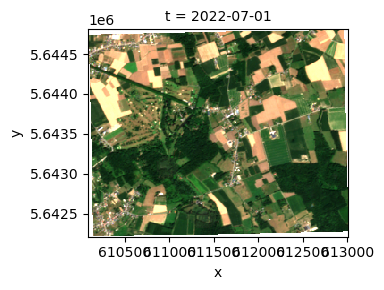

In [19]:
xr.plot.imshow(rgb_array,vmin=0,vmax=0.18,rgb="bands",col='t',col_wrap=2)